# Based on Programming Assignment 2: Beer recommendation

- 과제 목표: 뉴럴 네트워크 모델을 설계한 후 모델을 학습하여 각 맥주들의 embedding 들을 생성하고, 영화 embedding 을 활용하여 각 사용자에게 맞춤형 맥주를 추천

In [1]:
# Data analysis libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import mplcursors # Use this is for creating a cursor-interactive plot with "%matplotlib notebook"

from sklearn.decomposition import NMF # Use this for training Non-negative Matrix Factorization
from sklearn.utils.extmath import randomized_svd # Use this for training Singular Value Decomposition
from sklearn.manifold import TSNE # Use this for training t-sne manifolding
from sklearn.model_selection import train_test_split
#### 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity


from itertools import permutations # For making pairs

plt.style.use('ggplot') # You can also use different style

# just for plot checking, use this option
# %matplotlib inline

# for interactive plot
# If you use this option, plot will appear at first-drawn position
%matplotlib notebook

warnings.filterwarnings('ignore')


# Data loading

In [25]:
# Load flat file (Kaggle)
df_reviews_raw = pd.read_csv('beer_reviews.csv')

# Best Practice: Make a copy of the raw data to work on
df_reviews = df_reviews_raw.copy()

# Peep it
df_reviews.head()

# reviews = reviews.drop(["review_time", "brewery_name", "beer_name"], axis=1)
df_reviews = df_reviews.drop(["brewery_name", "beer_name"], axis=1) # timestamp 살려두기
#reviews_features = df_reviews.copy()

# Peep it
df_reviews.head()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_abv,beer_beerid
0,10325,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,5.0,47986
1,10325,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,6.2,48213
2,10325,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,6.5,48215
3,10325,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,5.0,47969
4,1075,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,7.7,64883


# Preprocessing data

<br>

> 타입을 category로 바꿔주기

<br>

In [26]:
# Convert 'object' to 'category' 
df_reviews[df_reviews.select_dtypes(['object']).columns] = df_reviews.select_dtypes(['object']).\
                                                         apply(lambda x: x.astype('category'))
# Examine structure 
df_reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   brewery_id          1586614 non-null  int64   
 1   review_time         1586614 non-null  int64   
 2   review_overall      1586614 non-null  float64 
 3   review_aroma        1586614 non-null  float64 
 4   review_appearance   1586614 non-null  float64 
 5   review_profilename  1586266 non-null  category
 6   beer_style          1586614 non-null  category
 7   review_palate       1586614 non-null  float64 
 8   review_taste        1586614 non-null  float64 
 9   beer_abv            1518829 non-null  float64 
 10  beer_beerid         1586614 non-null  int64   
dtypes: category(2), float64(6), int64(3)
memory usage: 117.8 MB



<br>

> 결측치 제거

<br>


In [27]:
# Check for null values
#print(df_reviews.isnull().sum())

# Percent of data missing `beer_abv` values
print("Percent Null Values of `beer_abv` column:", round(67785 / 1586614 * 100, 2),"%")

# Drop null row values
df_reviews = df_reviews.dropna()
#df_reviews.info()

# Check for null values
#print(df_reviews.isnull().sum())

# Percent of data that are null
print("Percent of Null Values:", round((1586614 - 1518478)/ 1586614 * 100, 2),"%")

Percent Null Values of `beer_abv` column: 4.27 %
Percent of Null Values: 4.29 %



<br>

> 중복 데이터 제거

<br>


In [28]:
# Sort by user overall rating first
df_reviews = df_reviews.sort_values('review_overall', ascending=False)

# Peep it
df_reviews.head()

# Keep the highest rating from each user and drop the rest 
df_reviews = df_reviews.drop_duplicates(subset= ['review_profilename','beer_beerid'], keep='first')

# Peep structure
#df_reviews.info()

# Percent of data that are duplicates
print("Percent of Duplicate Values:", round((1518478 - 1504037)/ 1518478 * 100, 2),"%")

Percent of Duplicate Values: 0.95 %



<br>

> 0점으로 기록된 데이터를 0 아닌 값으로 수정해주기

<br>


In [29]:
# Histogram of all numeric features
#reviews.hist(figsize=(12,12))
#plt.show()

# Sort by user overall rating first
df_reviews = df_reviews.sort_values('review_overall', ascending=True)

# Peep it
print(1504052 - 1504045, "개의 데이터에 문제 발생")
df_reviews[(df_reviews['review_overall'] < 1) | (df_reviews['review_appearance'] < 1)]


# Review scores of >= 1 : 문제 데이터 제거
df_reviews = df_reviews[(df_reviews['review_overall'] >= 1)]
#df_reviews = df_reviews[(df_reviews['review_appearance'] >= 1)]
# Peep it
df_reviews.head(8)

7 개의 데이터에 문제 발생


,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_abv,beer_beerid
1074603,677,1223493846,1.0,1.0,3.0,Marcus6679,Chile Beer,1.0,1.0,4.2,38763
1074607,677,1214606400,1.0,2.5,4.0,mikedgt,Chile Beer,3.0,1.5,4.2,38763
1074612,677,1178150667,1.0,1.0,1.0,zeff80,Chile Beer,1.0,1.0,4.2,2213
1074616,677,1206162572,1.0,1.0,2.5,ChainGangGuy,Chile Beer,2.0,1.0,4.2,38763
1074617,677,1204878541,1.0,2.0,2.0,mattster,Chile Beer,1.0,1.5,4.2,38763
1074620,677,1325988783,1.0,1.0,2.5,B967ierhunter177,Chile Beer,1.0,1.0,4.2,38763
534388,401,1123591124,1.0,1.5,2.0,Vancer,Euro Strong Lager,1.5,1.5,8.0,1967
1074630,677,1317421512,1.0,1.0,1.5,scottfrie,Chile Beer,1.0,1.0,4.2,38763



<br>

> 유저와 맥주와 총점만 있는 자료로 만들기

<br>


In [30]:
# Create Pandas DF of ratings by user and item
df_ratings = df_reviews[['review_profilename', 'beer_beerid', 'review_overall']]

# Rename columns
df_ratings = df_ratings.rename(columns = {'review_profilename':'userNm', 
                                    'review_overall':'rating',
                                    'beer_beerid' : 'beerId' })
df_ratings['reviewIdx'] = df_ratings.index


df_ratings.head()

# 고유 사용자, 고유 맥주 갯수 확인
n_users = len(df_ratings['userNm'].unique())
n_beers = len(df_ratings['beerId'].unique())

n_users, n_beers # (32908, 49011)

# df_ratings 기술통계량 확인
df_ratings['rating'].describe()
df_ratings.sort_values(by="beerId", ascending=True).head()

,userNm,beerId,rating,reviewIdx
393323,portia99,5,3.5,393323
393331,NODAK,5,4.0,393331
393594,Mustard,5,3.0,393594
393593,clvand0,5,3.0,393593
393406,everetends,5,4.0,393406



<br>

> 유저 

<br>


In [31]:
df_users = df_ratings.groupby('userNm').size().reset_index()
df_users.columns = ["userNm", "review_num"]

# 임의로(스펠링 순으로) 유저번호 붙이기
df_users['userIdx'] = df_users.index

print(df_users.head())

df_users = df_users.sort_values(by="review_num", ascending=False)

df_users['review_num'] = pd.to_numeric(df_users['review_num'])
df_users.head(1000) #479명의 리뷰 데이터가 없음

#df_users_500 = df_users[df_users["review_num"] >= 500]
#df_users_500# 리뷰를 500개 이상 작성한 654명의 유저만 사용


        userNm  review_num  userIdx
0     0110x011         137        0
1     01Ryan10           1        1
2     02maxima           4        2
3   03SVTCobra           3        3
4  04101Brewer           3        4


,userNm,review_num,userIdx
26927,northyorksammy,5311,26927
2351,BuckeyeNation,4240,2351
25703,mikesgroove,4226,25703
12378,Thorpe429,3272,12378
32912,womencantsail,3155,32912
...,...,...,...
17357,cnally,363,17357
32708,whartontallboy,363,32708
8564,Morey,363,8564
23068,jondeelee,363,23068


In [32]:
df_ratings_500 = df_ratings.merge(df_users, left_on = 'userNm', right_on = 'userNm', how = 'left')

df_ratings_500.sort_values(by="userIdx", ascending=True)


,userNm,beerId,rating,reviewIdx,review_num,userIdx
1459651,0110x011,7971,5.0,1134674,137,0
1465395,0110x011,2749,5.0,1088528,137,0
339278,0110x011,50331,3.5,224287,137,0
632169,0110x011,47922,4.0,132361,137,0
1407299,0110x011,35328,4.5,1520604,137,0
...,...,...,...,...,...,...
787326,zyzygy,28687,4.0,873579,5,33385
1293111,zyzygy,273,4.5,173551,5,33385
975916,zyzygy,1112,4.0,566468,5,33385
1146649,zyzygy,141,4.5,773245,5,33385


In [33]:
df_beers = df_ratings.groupby('beerId').size().reset_index()
df_beers.columns = ["beerId", "br_review_num"]
df_beers['br_review_num'] = pd.to_numeric(df_beers['br_review_num'])

#one_hot_movie = df_beers.copy()
# 임의로(스펠링 순으로) 유저번호 붙이기
#df_beers['userIdx'] = df_users.index

#print(df_beers.head())

df_beers = df_beers.sort_values(by="br_review_num", ascending=False)

df_beers.head() #479명의 리뷰 데이터가 없음

#df_users_500 = df_users[df_users["review_num"] >= 500]
#df_users_500# 리뷰를 500개 이상 작성한 654명의 유저만 사용

df_ratings_500 = df_ratings_500.merge(df_beers, left_on = 'beerId', right_on = 'beerId', how = 'left')
df_ratings_500.sort_values(by="beerId", ascending=True)


,userNm,beerId,rating,reviewIdx,review_num,userIdx,br_review_num
362785,portia99,5,3.5,393323,710,27995,420
638035,NODAK,5,4.0,393331,484,8831,420
116882,Mustard,5,3.0,393594,153,8766,420
116881,clvand0,5,3.0,393593,1178,17329,420
638060,everetends,5,4.0,393406,534,19686,420
...,...,...,...,...,...,...,...
1003376,Radome,77312,4.0,529418,193,10055,1
248543,Radome,77313,3.0,684958,193,10055,1
464224,Radome,77314,3.5,529417,193,10055,1
469278,thepeter,77315,3.5,992958,231,31443,1


# split dataframe  to test, train for cf model

In [34]:
# cf train, test set 나누기

df_cf_test = df_ratings_500[df_ratings_500["review_num"]<=2000]
df_cf_test = df_cf_test[df_cf_test["br_review_num"]<=500]

df_cf_train = df_ratings_500[df_ratings_500["review_num"]>2000]
df_cf_train = df_cf_train[df_cf_train["br_review_num"]>500]

df_cf_test.head(), df_cf_train.head()

df_cf_train_beers = df_beers[df_beers["br_review_num"]>500] #584개 맥주
df_cf_train_users = df_users[df_users["review_num"]  >2000] #44명 유저 

df_cf_test_beers = df_beers[df_beers["br_review_num"]<=500] #584개 제외 나머지 맥주
df_cf_test_users = df_users[df_users["review_num"]  <=2000] #44명 제외 나머지 유저


In [65]:
df_ratings_500 = df_ratings_500[df_ratings_500["review_num"]>2000]
df_ratings_500 = df_ratings_500[df_ratings_500["br_review_num"]>500]

#df_users.sort_values(by="userIdx", ascending=True).reset_index()
#df_beers.sort_values(by="beerId",  ascending=True)

df_ratings_500 # 총 리뷰 갯수 19695개
#df_ratings_500[df_ratings_500["br_review_num"]>1000]
#df_beers[df_beers["br_review_num"]>1000]


,userNm,beerId,rating,reviewIdx,review_num,userIdx,br_review_num
368,WVbeergeek,1524,1.0,1299581,2325,13002,525
425,Gusler,1524,1.0,1299542,2082,5382,525
525,zeff80,1524,1.0,1299278,2412,33297,525
570,Halcyondays,1524,1.0,1299633,2333,5455,525
581,Thorpe429,1524,1.0,1299652,3272,12378,525
...,...,...,...,...,...,...,...
1503390,Gusler,1577,5.0,451981,2082,5382,824
1503651,DrJay,1577,5.0,451813,2110,3965,824
1503652,Viggo,1577,5.0,451815,2352,12904,824
1503653,mikesgroove,1577,5.0,451724,4226,25703,824


# One-hot  encoding beerId

In [54]:
onehot_encoder = OneHotEncoder() #sparse=False)

one_hot_beers = df_cf_train_beers.copy()
one_hot_sorted_beers = one_hot_beers.sort_index()


one_hot_sorted_beerId = one_hot_sorted_beers.values[:,0].reshape(584, 1)
one_hot_beerId = one_hot_beers.values[:,0].reshape(584, 1)


onehot_sorted_encoded = onehot_encoder.fit_transform(one_hot_sorted_beerId)
onehot_encoded = onehot_encoder.fit_transform(one_hot_beerId)
onehot_encoded

<584x584 sparse matrix of type '<class 'numpy.float64'>'
	with 584 stored elements in Compressed Sparse Row format>

In [56]:
one_hot_sorted_beers["oneHot"] = (tuple(onehot_sorted_encoded.toarray().astype(int)))
one_hot_beers["oneHot"] = (tuple(onehot_encoded.toarray().astype(int)))

In [59]:
#one_hot_beers

one_hot_beers
one_hot_sorted_beers

,beerId,br_review_num,oneHot
1,6,871,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,7,655,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,10,708,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11,17,740,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13,19,590,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
36043,59151,605,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
36164,59369,566,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
36834,60420,864,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
38342,62645,517,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."



<br>

> one-hot beerId로 페어를 만들어서 학습을 진행한다.
> - 추후 추가할 과제: taste 정보등 rating과 관련이 높은 특징들을 준비한다.

<br>


In [81]:
one_hot_sorted = one_hot_sorted_beers.drop(columns=["br_review_num"])
df_ratings_encoded = df_ratings_500.merge(one_hot_sorted, left_on = 'beerId', right_on = 'beerId', how = 'left')
#df_ratings_500.sort_values(by="reviewIdx", ascending=True)
df_ratings_encoded.sort_values(by="beerId", ascending=True)

df_encoded = df_ratings_encoded.drop(columns=["br_review_num", "reviewIdx", "review_num", "userNm"])

df_encoded

,beerId,rating,userIdx,oneHot
0,1524,1.0,13002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1524,1.0,5382,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1524,1.0,33297,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1524,1.0,5455,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1524,1.0,12378,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
19690,1577,5.0,5382,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19691,1577,5.0,3965,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19692,1577,5.0,12904,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19693,1577,5.0,25703,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# making beer pair for  nn model


<br>

> 가정 : 유저가 마시고 평가를 내린 맥주들을 서로 유사할 것이다.
> - 추가 가정 : 유저가 평점을 비슷하게 내린 맥주끼리만 pair를 만드는 것이 정확도가 더 높지 않을까?

<br>


In [80]:
#사용자 마다 
df_cf_train_users.shape # 44 rows × 3 columns : 선별된 사용자 수 = 44
df_ratings_user_group = df_encoded.groupby(['userIdx', 'beerId']).mean()

df_ratings_user_group[df_ratings_user_group["userIdx"]== 934] 


rating
userIdx beerId        
934     6          3.0
        7          3.5
        10         4.5
        17         4.0
        19         4.0
...                ...
33297   57908      4.5
        59151      4.0
        59369      3.5
        60420      4.5
        72138      4.5

[19695 rows x 1 columns]

In [84]:
nn_train_data, nn_test_data = train_test_split(df_encoded, test_size = 0.2)

nn_train_data = nn_train_data.sort_values(["beerId"]) 
nn_test_data = nn_test_data.sort_values(["beerId"])

In [85]:
def pair_oneHot(data):
    pair_list = [] #pd.DataFrame([])

    for user_id in data['userIdx'].unique():
        # 유저 user_idx 가 평가한 맥주들
        item_list = data[data['userIdx'] == user_id]['oneHot']
        item_pair = list(permutations(item_list, 2))
        for i in item_pair:
            #item_1 = i[0]
            #item_2 = i[1]
            pair_list.append(i) #({"m1": movie_1}, {"m2" : movie_2}))
            
    return pair_list

train_pair = pair_oneHot(nn_train_data)
test_pair = pair_oneHot(nn_test_data)


In [88]:
train_pair

len(train_pair), len(test_pair)


(5842720, 370754)

# Build and train neural networks for generating movie embeddings


In [89]:
BATCH_SIZE = 1000

train_loader = torch.utils.data.DataLoader(dataset=train_pair, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_pair, batch_size=BATCH_SIZE, shuffle=False)  

train_loader.dataset

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    #print(X_train[0], y_train[0])
    print("x",X_train,"\ny", y_train)
    break

X_train: torch.Size([1000, 584]) type: torch.LongTensor
y_train: torch.Size([1000, 584]) type: torch.LongTensor
x tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]) 
y tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [90]:
len(train_loader)

5843

In [96]:
#1000x584
#mat1 and mat2 shapes cannot be multiplied (1000x584 and 1012x50)
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(584, 50) # batch_size = 32 = 11, input_dim=3072 = 92
        #self.bn = nn.BatchNorm1d(BATCH_SIZE) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 584)    # hidden_dim=10, output_dim=1012
        #self.sm = nn.Softmax(dim=0)

    def forward(self,x):
        #batch_size = x.size

        h = self.fc1(x)
        #h_bN = self.bn(h)
        l = self.relu(h)
        output = self.fc2(l)
        #s = self.sm(output)
        
        return output
    

In [97]:

def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500

    for batch_idx, a in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()

        (image, label) = a
        # 이미지를 (batch_size, -1) 차원의 메트릭스로 만드세요
        #batch_size = image.size()[0] #
        #image = image.reshape(batch_size, -1) #
        
        #print("image ", image, image.shape)
        image = torch.tensor(image, dtype = torch.float32)#.float()
        #print("label ",label)
        
        outputs = network(image)
        #print("outputs ", outputs, outputs.shape)
        
        #label = label.reshape(1, -1)
        label = torch.tensor(label, dtype = torch.float32)#torch.long)
        #print("label ", label, label.dtype, outputs.shape) # torch.int64
        
        # loss_func 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs, label)  #
        train_losses.append(loss.item())

        # Gradinet 구하기
        loss.backward()   #

        # weight값 update 하기
        optimizer.step()  #

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses


In [147]:
def training(network, learning_rate, epoches):
    
    cls_loss = nn.CrossEntropyLoss() #
    optimizer = optim.SGD(network.parameters(), learning_rate, weight_decay=0.01) #
    
    train_losses_per_epoch = []
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses = training_epoch(train_loader,network,cls_loss,optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)

    torch.save(network.state_dict(), 'weights_path.pth')
    w = torch.load('weights_path.pth')['fc1.weight']
    
    return w, train_losses_per_epoch




In [105]:
nn_model = Model()

weight, train_losses_per_epoch = training(nn_model, 0.005)


Train Epoch: 0 [0/5842720 (0%)]	Loss: 6.377292
Train Epoch: 0 [500000/5842720 (9%)]	Loss: 6.372082
Train Epoch: 0 [1000000/5842720 (17%)]	Loss: 6.371815
Train Epoch: 0 [1500000/5842720 (26%)]	Loss: 6.368135
Train Epoch: 0 [2000000/5842720 (34%)]	Loss: 6.373803
Train Epoch: 0 [2500000/5842720 (43%)]	Loss: 6.373055
Train Epoch: 0 [3000000/5842720 (51%)]	Loss: 6.371747
Train Epoch: 0 [3500000/5842720 (60%)]	Loss: 6.367995
Train Epoch: 0 [4000000/5842720 (68%)]	Loss: 6.371285
Train Epoch: 0 [4500000/5842720 (77%)]	Loss: 6.375082
Train Epoch: 0 [5000000/5842720 (86%)]	Loss: 6.369839
Train Epoch: 0 [5500000/5842720 (94%)]	Loss: 6.372185
Train Epoch: 1 [0/5842720 (0%)]	Loss: 6.373128
Train Epoch: 1 [500000/5842720 (9%)]	Loss: 6.368927
Train Epoch: 1 [1000000/5842720 (17%)]	Loss: 6.369916
Train Epoch: 1 [1500000/5842720 (26%)]	Loss: 6.366002
Train Epoch: 1 [2000000/5842720 (34%)]	Loss: 6.371174
Train Epoch: 1 [2500000/5842720 (43%)]	Loss: 6.370303
Train Epoch: 1 [3000000/5842720 (51%)]	Loss: 6

[6.370563097080098, 6.367740487636166, 6.366756418072441, 6.366367463561213, 6.366199422653827, 6.366122399048917, 6.366085941204362, 6.366068448225521, 6.36606001776415, 6.366055978807341, 6.366054059870334, 6.366053170584947, 6.366052763033215, 6.366052586432906, 6.366052507925744, 6.366052486952417, 6.366052484585777, 6.366052487686891, 6.366052492991429, 6.3660524935626865]


<IPython.core.display.Javascript object>


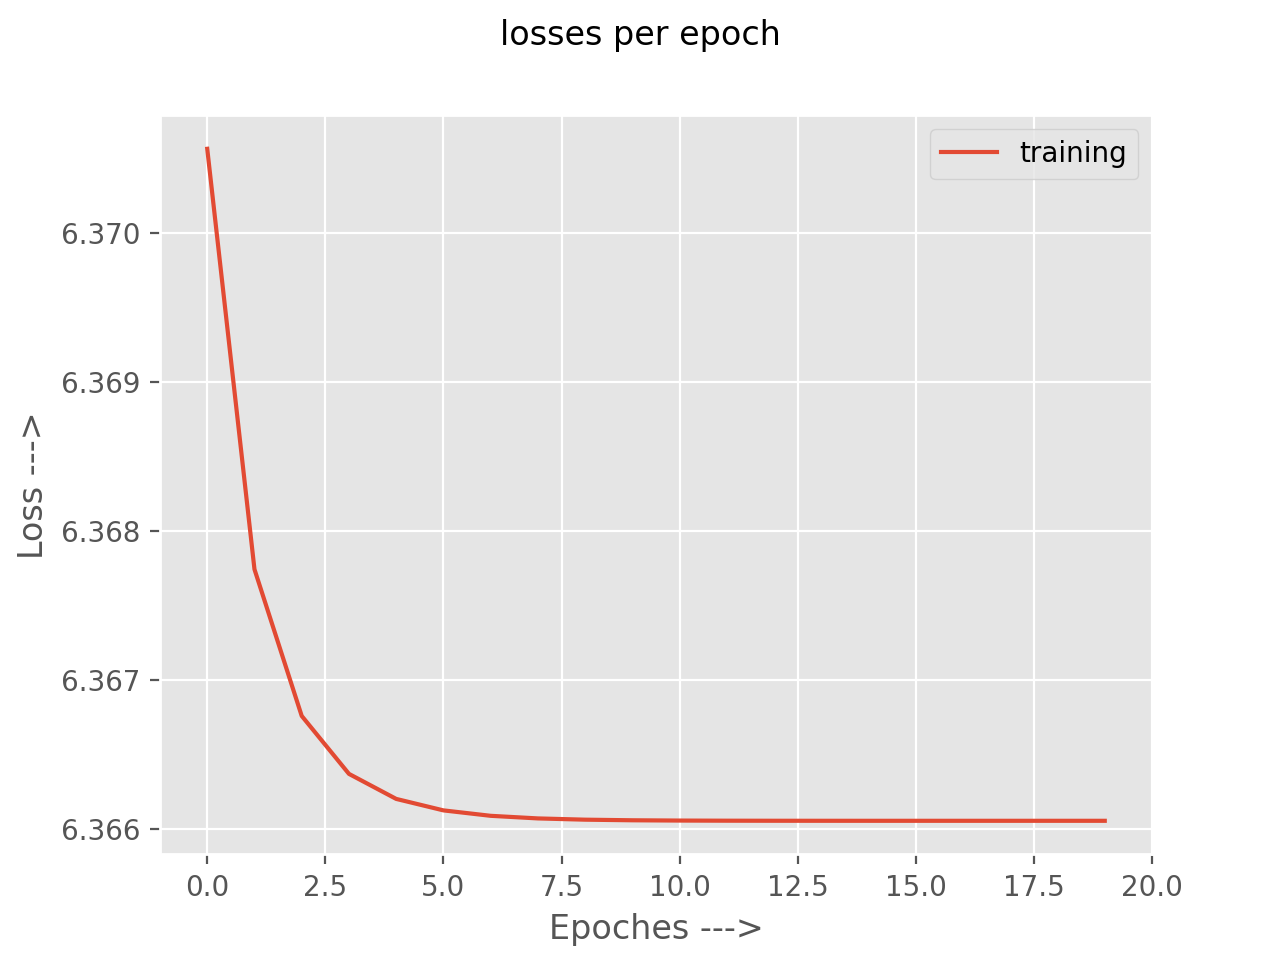

In [157]:
def show_rlt(train_losses_per_epoch,title, epoches):
    fig = plt.figure()

    fig.suptitle(title)
    ax1 = fig.add_subplot(111)

    x = np.arange(epoches)
  
    ax1.plot(x, train_losses_per_epoch)
    ax1.legend(['training'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([-1,epoches])

    plt.show()
    
print(train_losses_per_epoch)
epoches = 20
show_rlt(train_losses_per_epoch, 'losses per epoch', epoches)

[6.370563097080098, 6.367740487636166, 6.366756418072441, 6.366367463561213, 6.366199422653827, 6.366122399048917, 6.366085941204362, 6.366068448225521, 6.36606001776415, 6.366055978807341, 6.366054059870334, 6.366053170584947, 6.366052763033215, 6.366052586432906, 6.366052507925744, 6.366052486952417, 6.366052484585777, 6.366052487686891, 6.366052492991429, 6.3660524935626865]


<IPython.core.display.Javascript object>


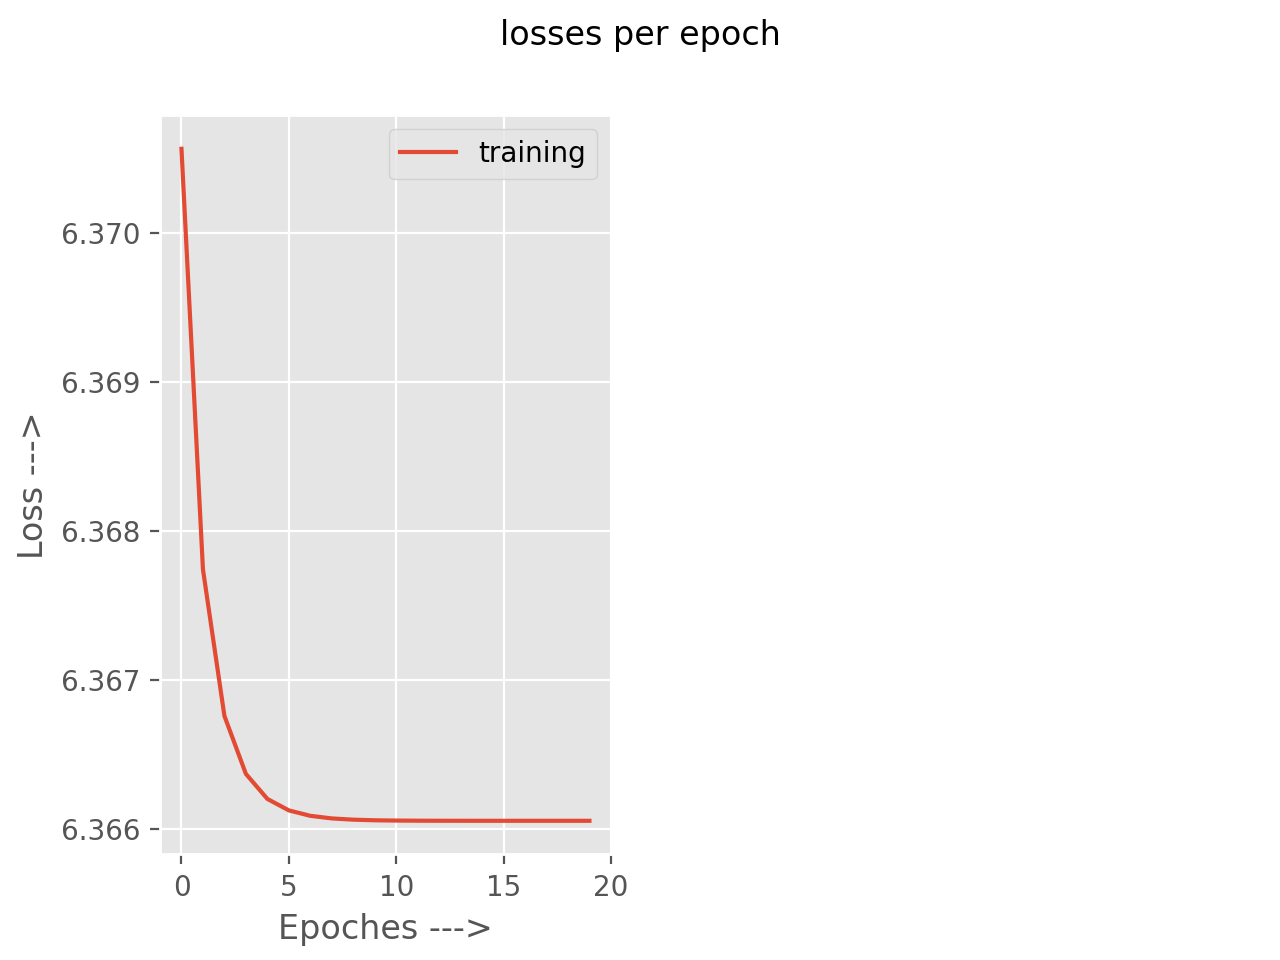

In [156]:
import matplotlib.pyplot as plt

#nn_model = Model()
epoches = 20
#weight, train_losses_per_epoch = training(nn_model, 0.01, epoches)

print(train_losses_per_epoch)
show_rlt(train_losses_per_epoch, 'losses per epoch', epoches)


In [154]:
"""nn_model = Model()

weight3, train_losses_per_epoch3 = training(nn_model, 0.03, epoches = 20)

print(train_losses_per_epoch3)
show_rlt(train_losses_per_epoch3, 'losses per epoch', epoches = 20)

"""

"nn_model = Model()\n\nweight3, train_losses_per_epoch3 = training(nn_model, 0.03, epoches = 20)\n\nprint(train_losses_per_epoch3)\nshow_rlt(train_losses_per_epoch3, 'losses per epoch', epoches = 20)\n\n"

In [155]:
#학습된 weight matrix  𝑊𝑖𝑛의 행/열벡터를 각 맥주에 대한 embedding vector로 간주하여 맥주의 embedding 들을 구할 수 있음.
print("beers embedding: ", weight)
print(weight.shape)

beers embedding:  tensor([[ 3.1445e-07,  1.3050e-07,  2.9994e-07,  ...,  7.4816e-08,
         -1.7487e-07,  3.3945e-07],
        [-2.8713e-07,  2.4249e-07, -1.9950e-07,  ..., -2.1124e-07,
         -1.9390e-07,  3.3095e-07],
        [ 3.4330e-08,  1.9510e-07,  1.1747e-07,  ...,  3.8778e-07,
          1.2030e-07,  1.1203e-07],
        ...,
        [ 2.3260e-07,  9.3894e-08, -3.3377e-07,  ...,  2.3200e-07,
          1.0370e-07,  1.6894e-07],
        [ 3.0676e-07,  1.1321e-07,  5.0181e-08,  ...,  9.7588e-08,
          1.6935e-07, -1.1017e-07],
        [ 2.0439e-07, -1.6745e-08,  5.6827e-08,  ..., -7.5471e-09,
          9.3801e-08,  2.6499e-07]])
torch.Size([50, 584])


In [122]:
df_reviews_detail = df_reviews.drop(["review_time", "review_aroma", "review_appearance", "beer_abv"], axis=1) # timestamp 살려두기

df_beers_detail = df_reviews_detail.drop(["review_overall", "review_profilename", "review_palate", "review_taste"], axis=1)

df_beers_detail

,brewery_id,beer_style,beer_beerid
1074603,677,Chile Beer,38763
1074607,677,Chile Beer,38763
1074612,677,Chile Beer,2213
1074616,677,Chile Beer,38763
1074617,677,Chile Beer,38763
...,...,...,...
454175,590,Märzen / Oktoberfest,6075
454192,590,Märzen / Oktoberfest,6075
454194,590,Märzen / Oktoberfest,6075
453840,590,Quadrupel (Quad),60675


In [176]:
one_hot_sorted
one_hot_sorted_index = one_hot_sorted.reset_index()
one_hot_sorted_index

df_beer_embedding = one_hot_sorted.merge(df_beers_detail, left_on = "beerId", right_on = "beer_beerid", how='left')
df_beer_embedding = df_beer_embedding.drop_duplicates("beerId")
df_beer_embedding


,beerId,oneHot,brewery_id,beer_style,beer_beerid
0,6,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,English Brown Ale,6
871,7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,Fruit / Vegetable Beer,7
1526,10,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,Dubbel,10
2234,17,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,American Pale Wheat Ale,17
2974,19,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,Milk / Sweet Stout,19
...,...,...,...,...,...
552481,59151,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10099,Russian Imperial Stout,59151
553086,59369,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",147,American Double / Imperial IPA,59369
553652,60420,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",140,American Brown Ale,60420
554516,62645,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",147,American Strong Ale,62645


In [231]:
df_ratings_encoded = df_ratings_encoded.sort_values("reviewIdx")
df_ratings_encoded


,userNm,beerId,rating,reviewIdx,review_num,userIdx,br_review_num,oneHot
13842,womencantsail,33644,4.5,4951,3155,32912,832,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8207,TMoney2591,33644,4.0,5100,2068,11876,832,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13827,Thorpe429,33644,4.5,5122,3272,12378,832,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8215,oberon,33644,4.0,5179,2879,27053,832,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8213,Mora2000,33644,4.0,5196,2373,8555,832,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
9746,Gusler,138,4.0,1584093,2082,5382,544,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4148,Jason,138,3.5,1584100,2041,6507,544,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19365,NeroFiddled,138,5.0,1584101,3068,8949,544,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9734,Gavage,138,4.0,1584115,2338,4990,544,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [263]:
# 추천해주고 싶은 유저 
user = 934

def cos_similiarity(v1, v2): 
    dot_product = np.dot(v1, v2) 
    l2_norm = (np.sqrt(sum(np.square(v1)))*np.sqrt(sum(np.square(v2)))) 
    similarity = dot_product/l2_norm 
    return similarity

def find_df_user_sim(userIdx):    
    list_userId = df_ratings_encoded[df_ratings_encoded['userIdx'] == userIdx]
    list_userId

    list_movieId = list_userId["beerId"].values
    list_movieId
    
    a_list = []
    a=0

    for i in list_movieId :
        index = one_hot_sorted_index[one_hot_sorted_index["beerId"] == i].index[0]
        rating = list_userId[list_userId["beerId"] == i]["rating"].values
        a_list.append(weight[:,index])
        a = (torch.add(weight[:,index]*rating, a))

    a = a/len(a_list)

    b = cosine_similarity(np.transpose(weight.numpy()), [a.numpy()])
    
    df_user_sim = df_beer_embedding.copy()
    df_user_sim['sim'] = b
    
    list_visted = list_userId.drop(columns=["userNm","rating","reviewIdx","review_num","br_review_num","oneHot","userIdx"])
    list_visted["visted_yes"] = 1
    
    df_user_sim = df_user_sim.merge(list_visted, left_on="beerId", right_on= "beerId", how = "left")
    
    return df_user_sim


In [267]:
df_v = find_df_user_sim(user)
df_recommending = df_v[df_v["visted_yes"]!=1]

df_recommending.sort_values(by="sim", ascending=False).head(5)


,beerId,oneHot,brewery_id,beer_style,beer_beerid,sim,visted_yes
170,1008,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",345,Weizenbock,1008,0.954475,NaN
287,2296,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",751,American Brown Ale,2296,0.952236,NaN
335,4109,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",694,Doppelbock,4109,0.949099,NaN
337,4394,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",141,American Double / Imperial IPA,4394,0.945565,NaN
493,34085,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2743,American Double / Imperial IPA,34085,0.942954,NaN
